In [1]:
!pip install -U fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 984.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=9e99790996a25d9ad53f4dc4ff475dcfb66127e622753d5454f446b246c77a8d
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=4d3fea3224fff283fae451cac3f949d0123cdbf85d7cae96a117ffec4c5db05f
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time
import requests
from torchvision.datasets import ImageFolder
from torchvision import models
from PIL import Image
from shutil import copyfile
import os
os.chdir('/content/drive/My Drive/MLDL_project')
from models.bisenet.build_bisenet import BiSeNet
from utils import fast_hist
from utils import per_class_iou
from utils import poly_lr_scheduler
from utils import latency_fps
from train import train
from validate import validation
import time
from torch.utils.data import RandomSampler
from timeit import default_timer as timer
from fvcore.nn import FlopCountAnalysis, flop_count_table
import matplotlib.pyplot as plt

In [4]:
from datasets.cityscapes import CityscapesDataset
from datasets.gta5 import GTA5

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
device

'cpu'

Defining dataloaders

In [7]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((720,1280), interpolation=Image.Resampling.NEAREST),
])

train_transform_aug2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.5),
    transforms.Resize((720, 1280), interpolation=Image.Resampling.NEAREST),
])

train_lbl_transform = transforms.Compose([
    transforms.Resize((720,1280), interpolation=Image.Resampling.NEAREST),
])



val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_lbl_transform = transforms.Compose([
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
])

In [8]:
train_dataset = GTA5('/content/drive/MyDrive/MLDL_project/datasets/GTA5', transform=[train_transform,train_lbl_transform]) # datasets\\GTA5
train_dataset_aug = GTA5('/content/drive/MyDrive/MLDL_project/datasets/GTA5', transform=[train_transform_aug2,train_lbl_transform]) # datasets\\GTA5
val_dataset = CityscapesDataset('/content/drive/MyDrive/MLDL_project/datasets/Cityspaces', split='train', transform=[val_transform,val_lbl_transform]) # datasets\\Cityscapes\\Cityspaces

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers = 8) #16
train_dataloader_aug = DataLoader(train_dataset_aug, batch_size=8, shuffle=False, num_workers = 8) #16
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers = 8) #16

Comparing image with and without augmentation

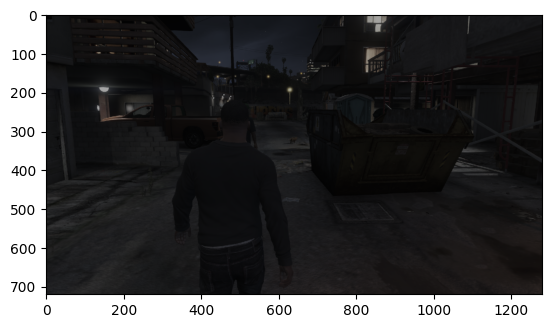

In [ ]:
# data_iter = iter(train_dataloader)
# inputs, _ = next(data_iter)
input_image = inputs[0]#.cuda()

plt.imshow(input_image.permute(1, 2, 0))
plt.show()

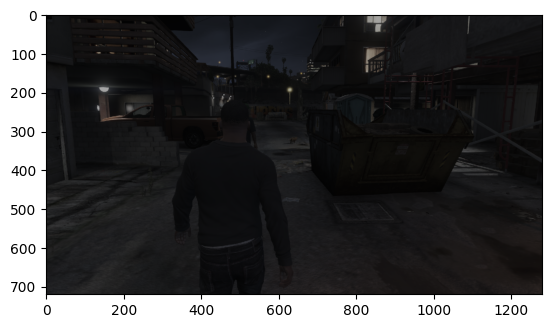

In [ ]:
# data_iter = iter(train_dataloader_aug)
# inputs, _ = next(data_iter)
input_image = inputs[0]#.cuda()

plt.imshow(input_image.permute(1, 2, 0))
plt.show()

Loading models

In [9]:
DIR = '/content/drive/MyDrive/MLDL_project/models/bisenet/trained_models/'

PATH1 = DIR + 'bisenet3a_epoch50_batchsize8.pth'
PATH2 = DIR + 'bisenet3b_aug2_epoch50_batchsize8.pth'
PATH3 = DIR + 'biseNet_UDA_epoch50.pth'

bisenet3a = BiSeNet(num_classes = 19, context_path='resnet18').to(device)
bisenet3a.load_state_dict(torch.load(PATH1,map_location=torch.device(device)))

bisenet3b = BiSeNet(num_classes = 19, context_path='resnet18').to(device)
bisenet3b.load_state_dict(torch.load(PATH2,map_location=torch.device(device)))

bisenetaug = BiSeNet(num_classes = 19, context_path='resnet18').to(device)
bisenetaug.load_state_dict(torch.load(PATH3,map_location=torch.device(device)))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 114MB/s]


<All keys matched successfully>

Plotting segmentations

In [10]:
from datasets.gta5Labels import GTA5Labels_TaskCV2017


def convert_model_output_to_rgb(model_output):

    model_output = torch.argmax(model_output, dim=1)
    model_output = model_output.squeeze(0)

    label_converter = GTA5Labels_TaskCV2017()
    h, w = model_output.shape
    rgb_output = np.zeros((h, w, 3))

    for i in range(h):
        for j in range(w):
            ID = int(model_output[i, j].item())
            rgb_output[i, j] = label_converter.trans_id_to_rgb().get(ID, (0, 0, 0)) # black for 255 ID

    return rgb_output.astype(int)

In [11]:
label_converter = GTA5Labels_TaskCV2017()
label_converter.trans_id_to_rgb().get(7, (0,0,0))

(220, 220, 0)

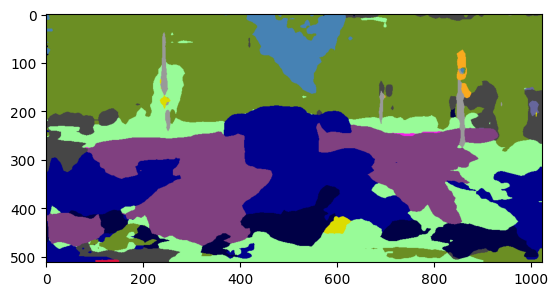

In [12]:
bisenet3a.eval()

data_iter = iter(val_dataloader)
inputs, _ = next(data_iter)
input_image = inputs[0].unsqueeze(0)#.cuda()

with torch.no_grad():
    output = bisenet3a(input_image)

rgb_output = convert_model_output_to_rgb(output)

plt.imshow(rgb_output)
plt.show()

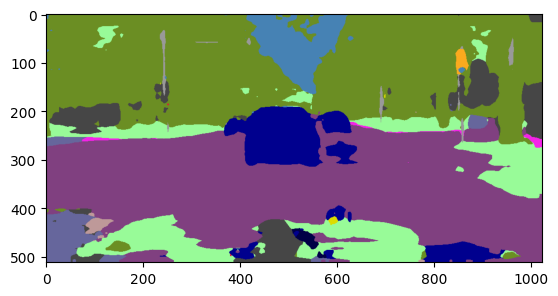

In [13]:
bisenet3b.eval()

with torch.no_grad():
    output = bisenet3b(input_image)

rgb_output = convert_model_output_to_rgb(output)

plt.imshow(rgb_output)
plt.show()

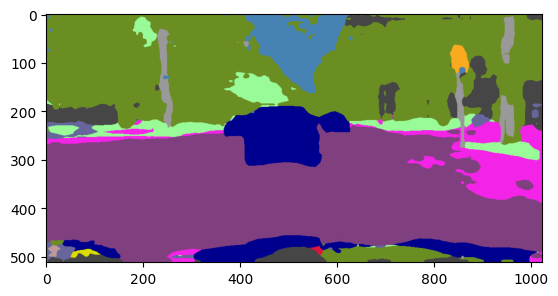

In [14]:
bisenetaug.eval()

with torch.no_grad():
    output = bisenetaug(input_image)

rgb_output = convert_model_output_to_rgb(output)

plt.imshow(rgb_output)
plt.show()